# Kobe Bryant Shot Selection

## Import custom R modules

In [1]:
source('R/utils/devdependencies.R');
source('R/pre-processing/preprocessing.R');
source('R/pre-processing/datavis.R');

## Install dependencies

In [2]:
install_dependencies();

[1] "Installing Project dependencies/libraries... Please wait"
[1] "Status: Success"


In [3]:
# Loading libraries
library(ggplot2)
library(GGally)
library(corrplot)
library(caret)
library(nnet)
library(e1071)
library(randomForest)
library(RSNNS)
require(grid)

Warning message:
"package 'ggplot2' was built under R version 3.3.2"Warning message:
"package 'GGally' was built under R version 3.3.2"Warning message:
"package 'corrplot' was built under R version 3.3.2"Warning message:
"package 'caret' was built under R version 3.3.2"Loading required package: lattice
Warning message:
"package 'e1071' was built under R version 3.3.2"Warning message:
"package 'randomForest' was built under R version 3.3.2"randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

Warning message:
"package 'RSNNS' was built under R version 3.3.2"Loading required package: Rcpp

Attaching package: 'RSNNS'

The following objects are masked from 'package:caret':

    confusionMatrix, train

Loading required package: grid


## Read the data into memory

In [4]:
# Get the csv file from the zip file
raw_data <- read.table(unz("data/rawdata_csv.zip", "data.csv"), header=T, quote="\"", sep=",");

# Print the head of the dataframe to understand the data structure
head(raw_data)

action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


## Understanding the variables

In [5]:
colnames(raw_data)

[1] "action_type"        "combined_shot_type" "game_event_id"     
 [4] "game_id"            "lat"                "loc_x"             
 [7] "loc_y"              "lon"                "minutes_remaining" 
[10] "period"             "playoffs"           "season"            
[13] "seconds_remaining"  "shot_distance"      "shot_made_flag"    
[16] "shot_type"          "shot_zone_area"     "shot_zone_basic"   
[19] "shot_zone_range"    "team_id"            "team_name"         
[22] "game_date"          "matchup"            "opponent"          
[25] "shot_id"

## Separating data from submission samples

In [6]:
dataframe <- na.omit(raw_data)
submission_sample <- raw_data[is.na(raw_data$shot_made_flag),]

## Statistical Analysis (Descriptive statistics)

In [7]:
# Pick the numeric variables only
numeric_columns <- dataframe[,sapply(dataframe, class) != 'factor']
summary(numeric_columns)

 game_event_id      game_id              lat            loc_x         
 Min.   :  2.0   Min.   :20000012   Min.   :33.25   Min.   :-250.000  
 1st Qu.:111.0   1st Qu.:20500064   1st Qu.:33.88   1st Qu.: -67.000  
 Median :253.0   Median :20900337   Median :33.97   Median :   0.000  
 Mean   :249.3   Mean   :24741091   Mean   :33.95   Mean   :   7.148  
 3rd Qu.:367.0   3rd Qu.:29600270   3rd Qu.:34.04   3rd Qu.:  94.000  
 Max.   :653.0   Max.   :49900088   Max.   :34.09   Max.   : 248.000  
     loc_y             lon         minutes_remaining     period     
 Min.   :-44.00   Min.   :-118.5   Min.   : 0.000    Min.   :1.000  
 1st Qu.:  4.00   1st Qu.:-118.3   1st Qu.: 2.000    1st Qu.:1.000  
 Median : 74.00   Median :-118.3   Median : 5.000    Median :3.000  
 Mean   : 91.26   Mean   :-118.3   Mean   : 4.887    Mean   :2.521  
 3rd Qu.:160.00   3rd Qu.:-118.2   3rd Qu.: 8.000    3rd Qu.:3.000  
 Max.   :791.00   Max.   :-118.0   Max.   :11.000    Max.   :7.000  
    playoffs      se

In [8]:
categorical_columns <- dataframe[,sapply(dataframe, class) == 'factor']
summary(categorical_columns)

               action_type    combined_shot_type     season     
 Jump Shot           :15836   Bank Shot:  120    2005-06: 1924  
 Layup Shot          : 2154   Dunk     : 1056    2002-03: 1852  
 Driving Layup Shot  : 1628   Hook Shot:  127    2008-09: 1851  
 Turnaround Jump Shot:  891   Jump Shot:19710    2007-08: 1819  
 Fadeaway Jump Shot  :  872   Layup    : 4532    2009-10: 1772  
 Running Jump Shot   :  779   Tip Shot :  152    2001-02: 1708  
 (Other)             : 3537                      (Other):14771  
          shot_type                   shot_zone_area 
 2PT Field Goal:20285   Back Court(BC)       :   72  
 3PT Field Goal: 5412   Center(C)            :11289  
                        Left Side Center(LC) : 3364  
                        Left Side(L)         : 3132  
                        Right Side Center(RC): 3981  
                        Right Side(R)        : 3859  
                                                     
              shot_zone_basic         shot_zone_

## Data visualization

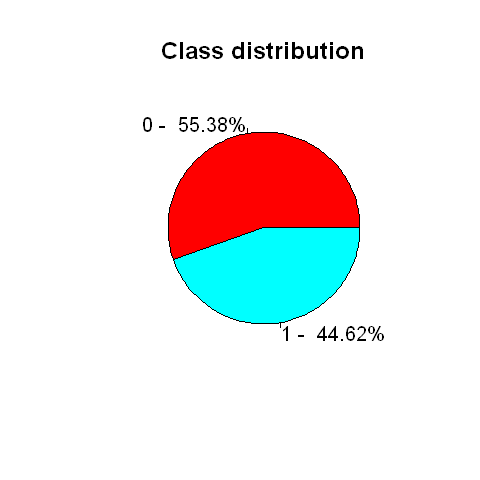

In [9]:
# Class distribution
prop <- c(sum(dataframe$shot_made_flag == 0), sum(dataframe$shot_made_flag == 1))/nrow(dataframe)
lbls <- c("0 - ", "1 - ")
lbls <- paste(lbls, format(round(prop*100, 2), nsmall = 2))
lbls <- paste(lbls, "%", sep="")

options(repr.plot.width=4, repr.plot.height=4)
pie(prop, labels=lbls, col=rainbow(length(lbls)), main="Class distribution")

### Spatial variables

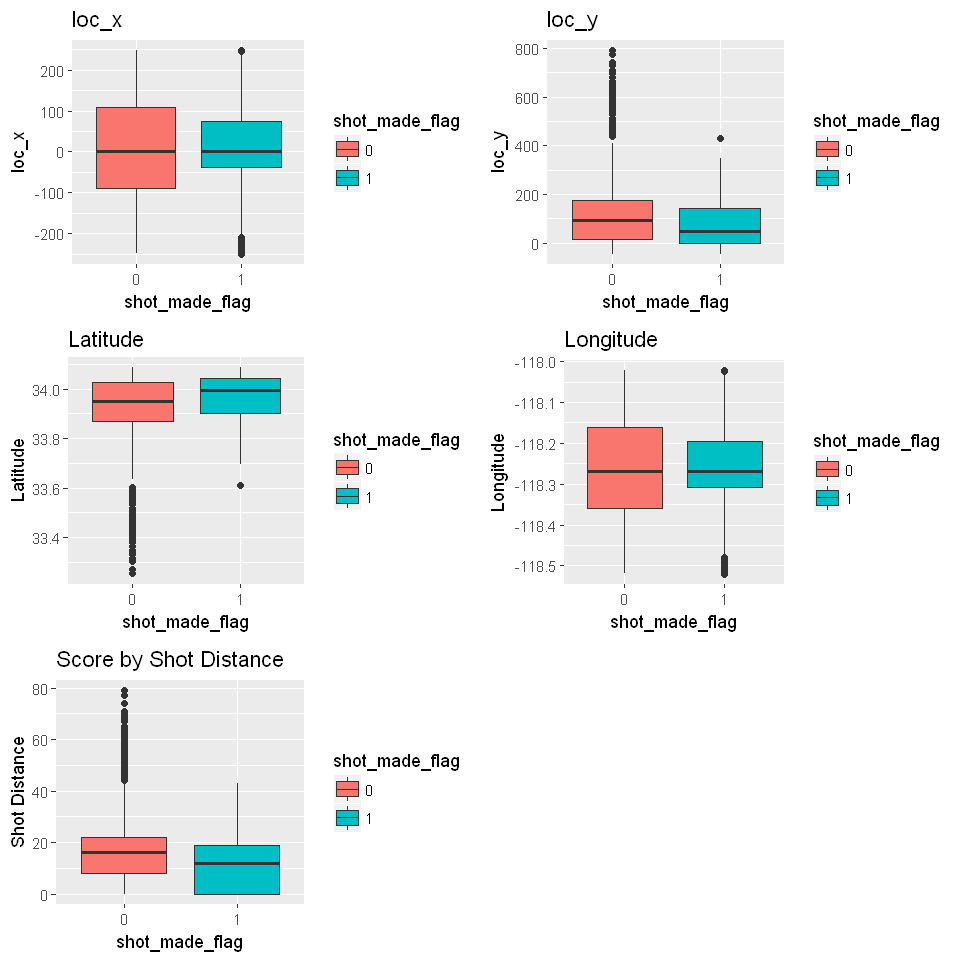

In [10]:
# Quartiles of 'loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'
dataframe$shot_made_flag <- factor(dataframe$shot_made_flag,levels=c(0,1), labels=c("0","1"))

# shot_distance
shot_dist_plot <- qplot(shot_made_flag, shot_distance, data=dataframe, geom=c("boxplot"), 
   fill=shot_made_flag, main="Score by Shot Distance", ylab="Shot Distance")

# Loc_x and Loc_y
loc_x_plot <- qplot(shot_made_flag, loc_x, data=dataframe, geom=c("boxplot"), 
   fill=shot_made_flag, main="loc_x", ylab="loc_x")

loc_y_plot <- qplot(shot_made_flag, loc_y, data=dataframe, geom=c("boxplot"), 
   fill=shot_made_flag, main="loc_y", ylab="loc_y")

# Lat and Lon
lat_plot <- qplot(shot_made_flag, lat, data=dataframe, geom=c("boxplot"), 
   fill=shot_made_flag, main="Latitude", ylab="Latitude")

lon_plot <- qplot(shot_made_flag, lon, data=dataframe, geom=c("boxplot"), 
   fill=shot_made_flag, main="Longitude", ylab="Longitude")

options(repr.plot.width=8, repr.plot.height=8)
multiplot(loc_x_plot, loc_y_plot, lat_plot, lon_plot, shot_dist_plot, cols=2)

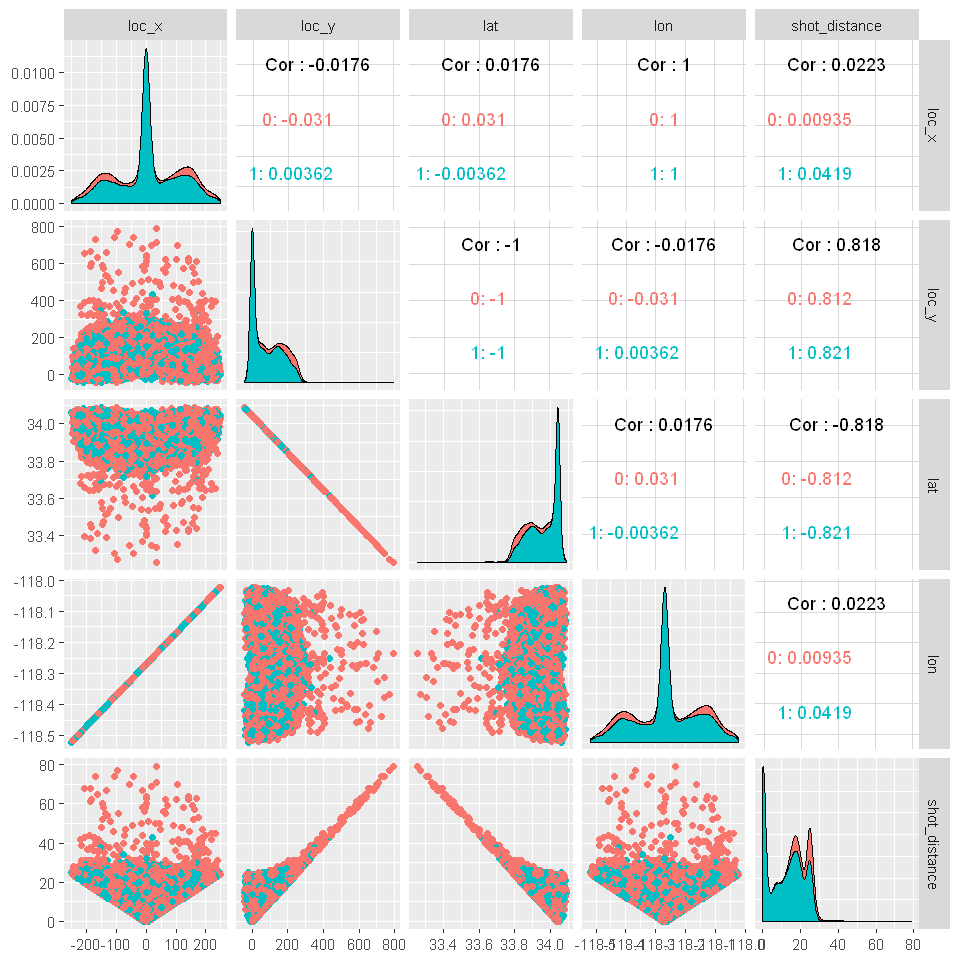

In [11]:
# Scatter matrix of 'loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'
options(repr.plot.width=8, repr.plot.height=8)
pm <- ggpairs(dataframe, mapping = aes(color = shot_made_flag), columns = c("loc_x", "loc_y", "lat", "lon", "shot_distance"))
pm

### Correlation Matrix

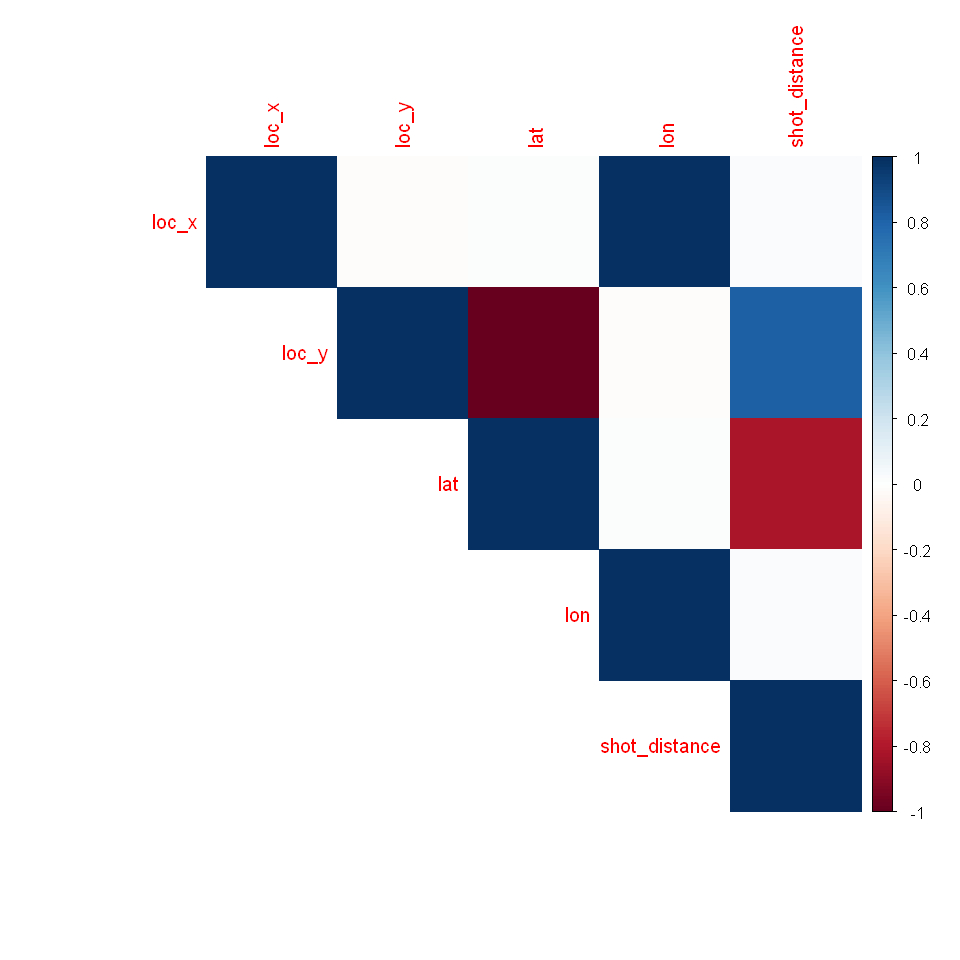

In [12]:
# Print and save the correlation matrix
x <- dataframe[,c("loc_x", "loc_y", "lat", "lon", "shot_distance")]
corrplot(cor(x), method="color", type="upper")

### Barplots of the other variables

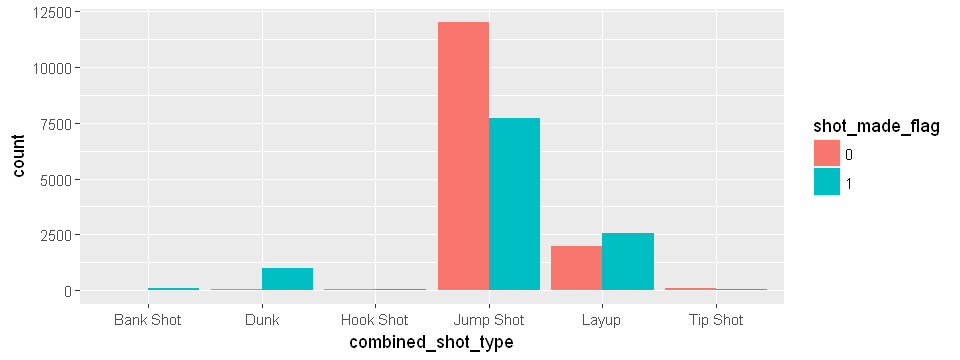

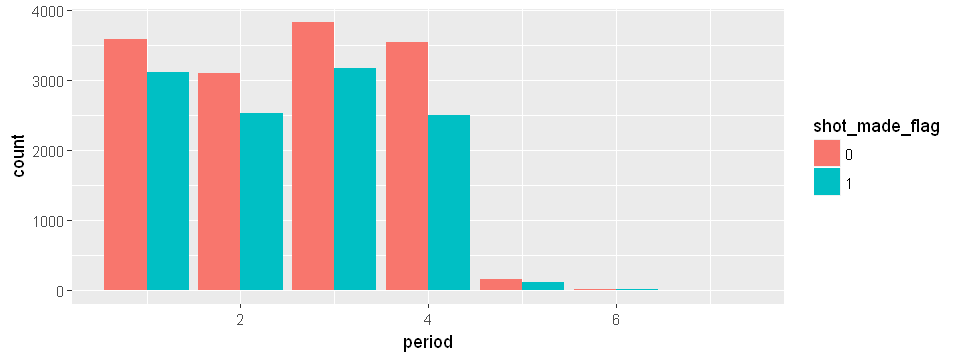

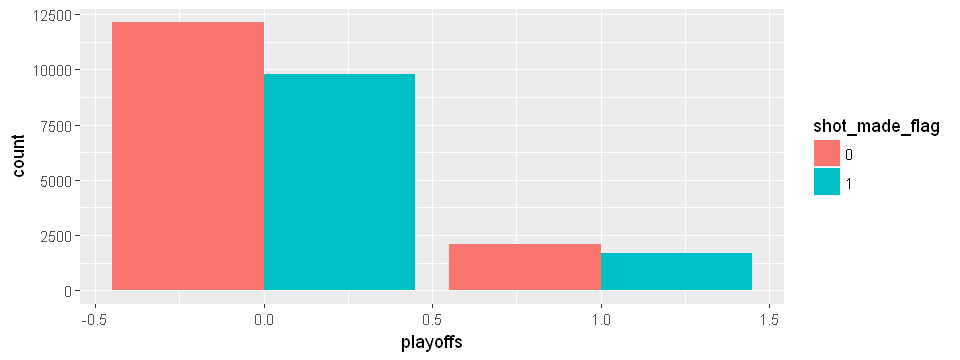

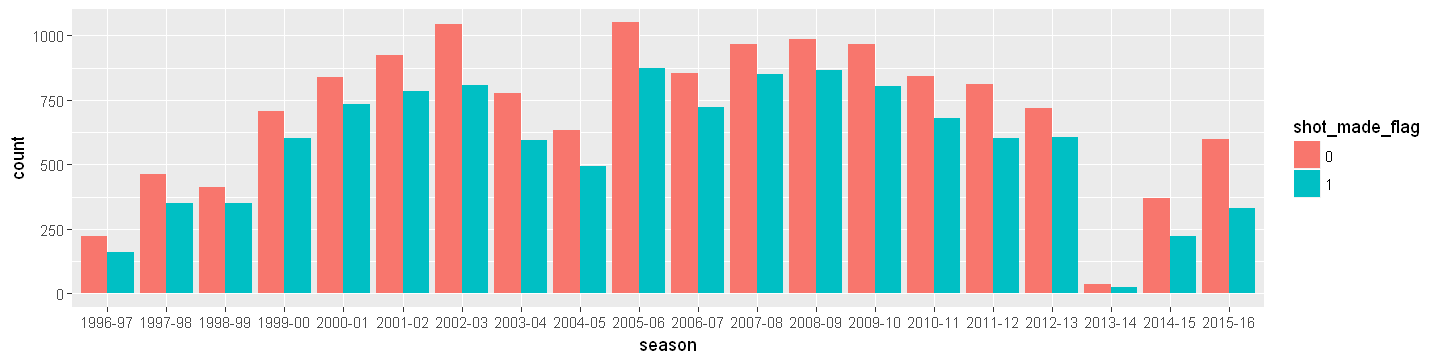

In [13]:
# combined_shot_type,season, period, playoffs, shot_type, shot_zone_area, shot_zone_basic, shot_zone_range
options(repr.plot.width=8, repr.plot.height=3)
ggplot(dataframe, aes(combined_shot_type, fill=shot_made_flag)) + geom_bar(position="dodge")
ggplot(dataframe, aes(period, fill=shot_made_flag)) + geom_bar(position="dodge")
ggplot(dataframe, aes(playoffs, fill=shot_made_flag)) + geom_bar(position="dodge")

options(repr.plot.width=12, repr.plot.height=3)
ggplot(dataframe, aes(season, fill=shot_made_flag)) + geom_bar(position="dodge")


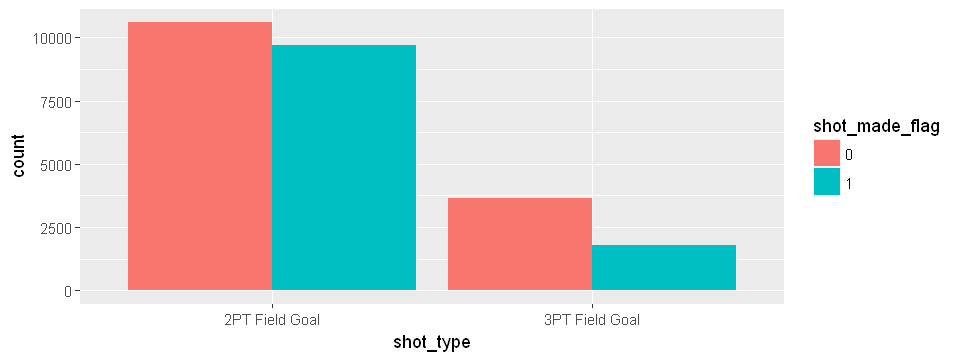

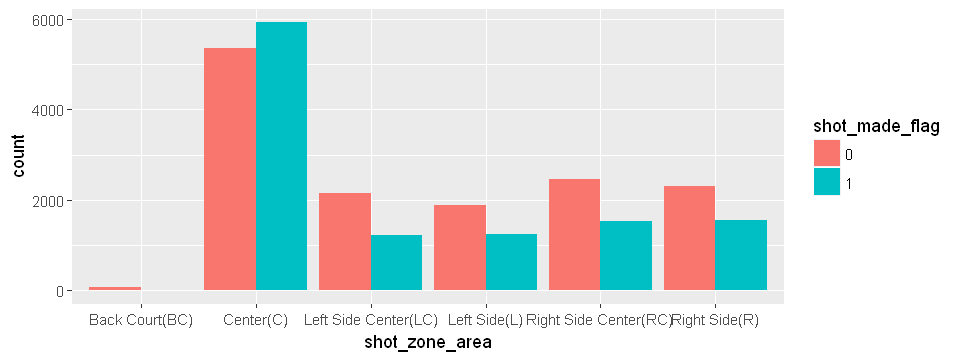

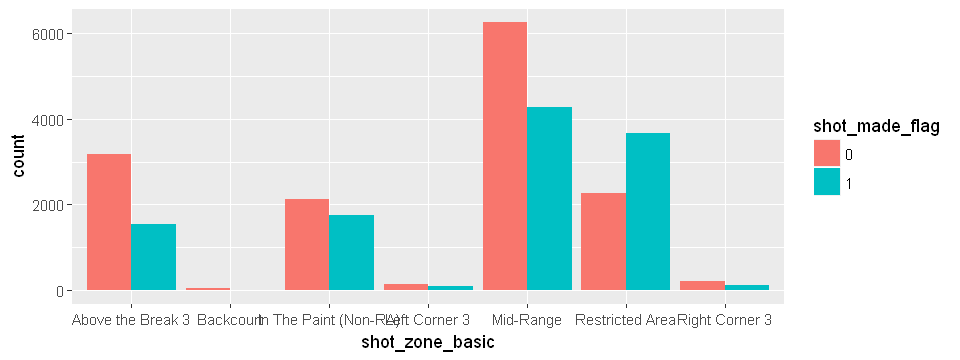

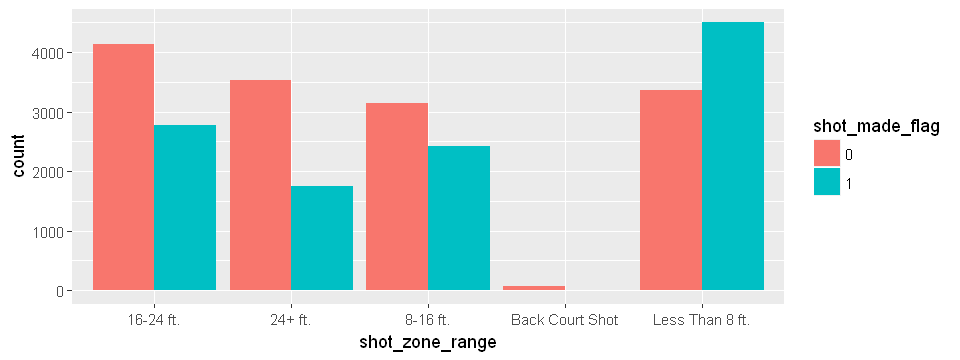

In [14]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(dataframe, aes(shot_type, fill=shot_made_flag)) + geom_bar(position="dodge")
ggplot(dataframe, aes(shot_zone_area, fill=shot_made_flag)) + geom_bar(position="dodge")
ggplot(dataframe, aes(shot_zone_basic, fill=shot_made_flag)) + geom_bar(position="dodge")
ggplot(dataframe, aes(shot_zone_range, fill=shot_made_flag)) + geom_bar(position="dodge")

### Histograms

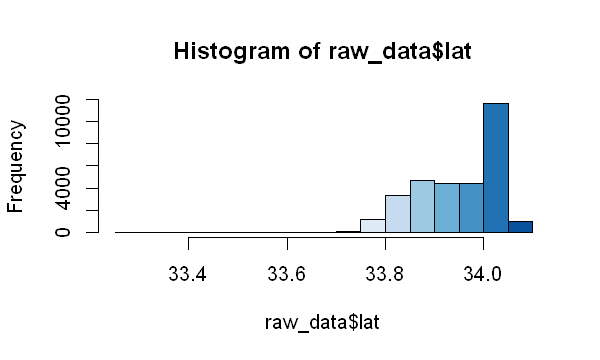

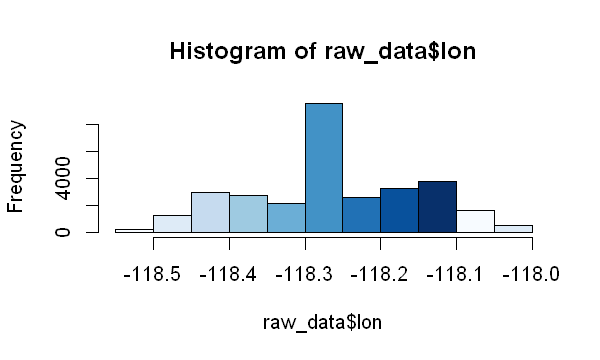

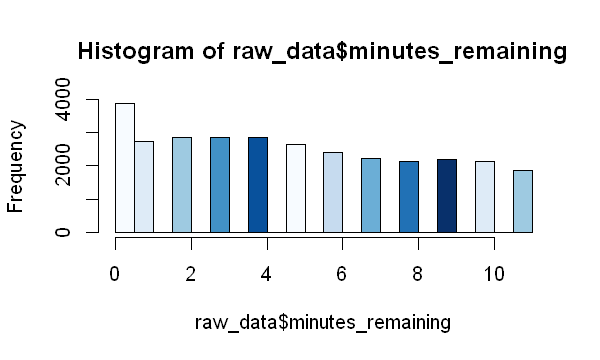

In [15]:
options(repr.plot.width=5, repr.plot.height=3)
hist(raw_data$lat, col=blues9)
hist(raw_data$lon, col=blues9)
hist(raw_data$minutes_remaining, col=blues9)

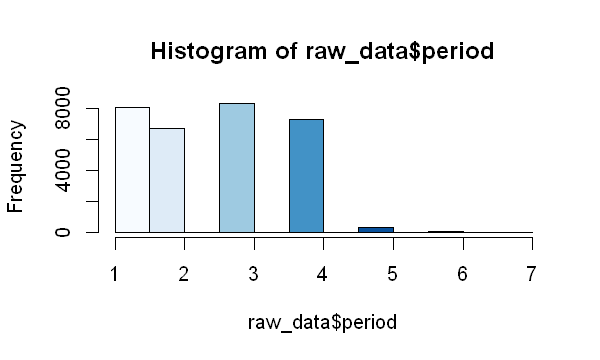

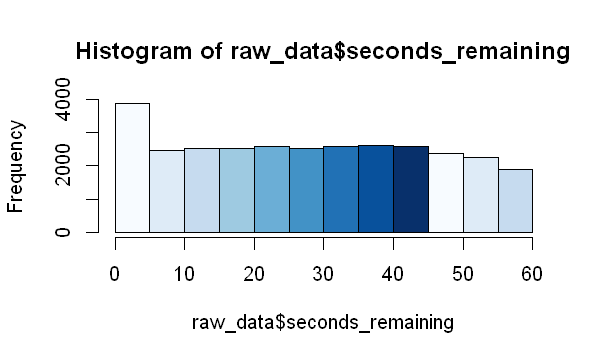

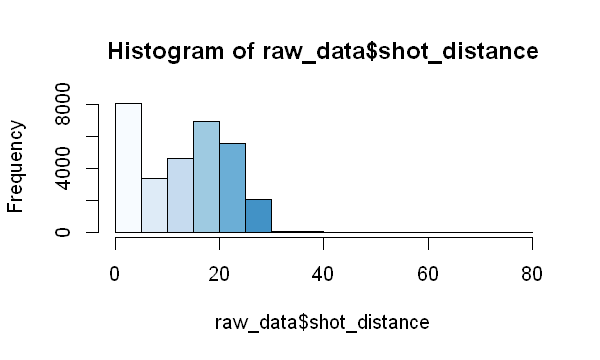

In [16]:
options(repr.plot.width=5, repr.plot.height=3)
hist(raw_data$period, col=blues9)
hist(raw_data$seconds_remaining, col=blues9)
hist(raw_data$shot_distance, col=blues9)

## Prepare Data

### Data Cleaning

In [17]:
#Remove unnecessary columns. Note that lat and lon are correlated with loc_x and loc_y
data_cl <- subset(dataframe, select = -c(shot_id, team_id, lat, lon, game_id, game_event_id, team_name))

## Data Transformation

In [18]:
#Time
data_cl['seconds_to_end'] = data_cl['minutes_remaining'] * 60 + data_cl['seconds_remaining']
data_cl <- subset(data_cl, select = -c(minutes_remaining, seconds_remaining))

#Game date
dates = as.Date(data_cl$game_date, format="%Y-%m-%d")

data_cl['game_year'] = as.numeric(strftime(dates, "%Y"))
data_cl['game_month'] = as.numeric(strftime(dates, "%m"))
data_cl <- subset(data_cl, select = -c(game_date))

#Away home
data_cl['away_home'] = as.integer(grepl("vs.", data_cl$matchup))
data_cl <- subset(data_cl, select = -c(matchup))

In [19]:
# Check the clean data
head(data_cl)

,action_type,combined_shot_type,loc_x,loc_y,period,playoffs,season,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,seconds_to_end,game_year,game_month,away_home
2,Jump Shot,Jump Shot,-157,0,1,0,2000-01,15,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,622,2000,10,0
3,Jump Shot,Jump Shot,-101,135,1,0,2000-01,16,1,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR,465,2000,10,0
4,Jump Shot,Jump Shot,138,175,1,0,2000-01,22,0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR,412,2000,10,0
5,Driving Dunk Shot,Dunk,0,0,2,0,2000-01,0,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,379,2000,10,0
6,Jump Shot,Jump Shot,-145,-11,3,0,2000-01,14,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,572,2000,10,0
7,Layup Shot,Layup,0,0,3,0,2000-01,0,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,532,2000,10,0


## Normalize the data

In [20]:
#'loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'
num_columns <- c('loc_x', 'loc_y', 'lat', 'lon', 'shot_distance', 'seconds_to_end');
preprocessParams <- preProcess(data_cl[, (colnames(data_cl) %in% num_columns)], method=c("center", "scale"))
data_cl <- predict(preprocessParams, data_cl);

# Visualize normalized data
head(data_cl)

,action_type,combined_shot_type,loc_x,loc_y,period,playoffs,season,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,seconds_to_end,game_year,game_month,away_home
2,Jump Shot,Jump Shot,-1.49126674,-1.0352259,1,0,2000-01,0.16433583,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,1.4424614,2000,10,0
3,Jump Shot,Jump Shot,-0.98251413,0.4962179,1,0,2000-01,0.27084656,1,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR,0.6887808,2000,10,0
4,Jump Shot,Jump Shot,1.18876931,0.9499791,1,0,2000-01,0.90991099,0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR,0.4343537,2000,10,0
5,Driving Dunk Shot,Dunk,-0.06494247,-1.0352259,2,0,2000-01,-1.43332523,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,0.2759367,2000,10,0
6,Jump Shot,Jump Shot,-1.38224832,-1.1600102,3,0,2000-01,0.05782509,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,1.2024357,2000,10,0
7,Layup Shot,Layup,-0.06494247,-1.0352259,3,0,2000-01,-1.43332523,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,1.0104152,2000,10,0


## Manipulate Categorical variables

In [21]:
# Period
data_cl$period[data_cl$period > 4] <- 'Others'
print(paste("Elements on data_cl$period: ", paste(unique(data_cl$period), collapse = ', ')))

# shot made flag
levels(data_cl$shot_made_flag) <- c("No", "Yes");
data_cl$shot_made_flag <- factor(data_cl$shot_made_flag);

head(data_cl$shot_made_flag)


[1] "Elements on data_cl$period:  1, 2, 3, 4, Others"


[1] No  Yes No  Yes No  Yes
Levels: No Yes

## Convert Categorical Variables into Indicator Variables

In [22]:
#Get the categorical columns

cols_to_be_dummy = list(
    'action_type', 'combined_shot_type', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'opponent',
    'period'
)

for (col in cols_to_be_dummy) {
    dummy_cols = unique(getElement(data_cl, col))
    concat_dummy_cols = paste(col ,"#", dummy_cols, sep = "")
    
    data_cl[col] <- as.character(getElement(data_cl, col))
    
    for (i in 1:length(dummy_cols)) {
        dummy_col = dummy_cols[i]
        concat_dummy_col = concat_dummy_cols[i]
        
        #Add the column
        data_cl[concat_dummy_col] <- 0
        
        #Fill with 1's
        b = getElement(data_cl, concat_dummy_col)
        binary = getElement(data_cl, col) == dummy_col
        b[binary] <- 1
        data_cl[concat_dummy_col] <- b
    }
}

#Remove the categorical columns
`%ni%` <- Negate(`%in%`)
data_cl <- subset(data_cl, select = names(data_cl) %ni% cols_to_be_dummy)

In [23]:
#Check the data_cl
colnames(data_cl)
paste("Number of columns = ", ncol(data_cl))
head(data_cl)

[1] "loc_x"                                      
  [2] "loc_y"                                      
  [3] "playoffs"                                   
  [4] "shot_distance"                              
  [5] "shot_made_flag"                             
  [6] "seconds_to_end"                             
  [7] "game_year"                                  
  [8] "game_month"                                 
  [9] "away_home"                                  
 [10] "action_type#Jump Shot"                      
 [11] "action_type#Driving Dunk Shot"              
 [12] "action_type#Layup Shot"                     
 [13] "action_type#Running Jump Shot"              
 [14] "action_type#Reverse Dunk Shot"              
 [15] "action_type#Slam Dunk Shot"                 
 [16] "action_type#Driving Layup Shot"             
 [17] "action_type#Turnaround Jump Shot"           
 [18] "action_type#Reverse Layup Shot"             
 [19] "action_type#Tip Shot"                       
 [20] "action_type#Running Hook Shot"              
 [21] "action_type#Alley Oop Dunk Shot"            
 [22] "action_type#Dunk Shot"                      
 [23] "action_type#Alley Oop Layup shot"           
 [24] "action_type#Running Dunk Shot"              
 [25] "action_type#Driving Finger Roll Shot"       
 [26] "action_type#Running Layup Shot"             
 [27] "action_type#Finger Roll Shot"               
 [28] "action_type#Fadeaway Jump Shot"             
 [29] "action_type#Follow Up Dunk Shot"            
 [30] "action_type#Hook Shot"                      
 [31] "action_type#Turnaround Hook Shot"           
 [32] "action_type#Jump Hook Shot"                 
 [33] "action_type#Running Finger Roll Shot"       
 [34] "action_type#Jump Bank Shot"                 
 [35] "action_type#Turnaround Finger Roll Shot"    
 [36] "action_type#Hook Bank Shot"                 
 [37] "action_type#Driving Hook Shot"              
 [38] "action_type#Running Tip Shot"               
 [39] "action_type#Running Reverse Layup Shot"     
 [40] "action_type#Driving Finger Roll Layup Shot" 
 [41] "action_type#Fadeaway Bank shot"             
 [42] "action_type#Pullup Jump shot"               
 [43] "action_type#Finger Roll Layup Shot"         
 [44] "action_type#Turnaround Fadeaway shot"       
 [45] "action_type#Driving Reverse Layup Shot"     
 [46] "action_type#Driving Slam Dunk Shot"         
 [47] "action_type#Step Back Jump shot"            
 [48] "action_type#Turnaround Bank shot"           
 [49] "action_type#Reverse Slam Dunk Shot"         
 [50] "action_type#Floating Jump shot"             
 [51] "action_type#Putback Slam Dunk Shot"         
 [52] "action_type#Running Bank shot"              
 [53] "action_type#Driving Bank shot"              
 [54] "action_type#Driving Jump shot"              
 [55] "action_type#Putback Layup Shot"             
 [56] "action_type#Putback Dunk Shot"              
 [57] "action_type#Running Finger Roll Layup Shot" 
 [58] "action_type#Pullup Bank shot"               
 [59] "action_type#Running Slam Dunk Shot"         
 [60] "action_type#Cutting Layup Shot"             
 [61] "action_type#Driving Floating Jump Shot"     
 [62] "action_type#Running Pull-Up Jump Shot"      
 [63] "action_type#Tip Layup Shot"                 
 [64] "action_type#Driving Floating Bank Jump Shot"
 [65] "combined_shot_type#Jump Shot"               
 [66] "combined_shot_type#Dunk"                    
 [67] "combined_shot_type#Layup"                   
 [68] "combined_shot_type#Tip Shot"                
 [69] "combined_shot_type#Hook Shot"               
 [70] "combined_shot_type#Bank Shot"               
 [71] "season#2000-01"                             
 [72] "season#2001-02"                             
 [73] "season#2002-03"                             
 [74] "season#2003-04"                             
 [75] "season#2004-05"                             
 [76] "season#2005-06"                             
 [77] "season#2006-07"                            

[1] "Number of columns =  148"

,loc_x,loc_y,playoffs,shot_distance,shot_made_flag,seconds_to_end,game_year,game_month,away_home,action_type#Jump Shot,...,opponent#BOS,opponent#NOH,opponent#NOP,opponent#OKC,opponent#BKN,period#1,period#2,period#3,period#4,period#Others
2,-1.49126674,-1.0352259,0,0.16433583,No,1.4424614,2000,10,0,1,...,0,0,0,0,0,1,0,0,0,0
3,-0.98251413,0.4962179,0,0.27084656,Yes,0.6887808,2000,10,0,1,...,0,0,0,0,0,1,0,0,0,0
4,1.18876931,0.9499791,0,0.90991099,No,0.4343537,2000,10,0,1,...,0,0,0,0,0,1,0,0,0,0
5,-0.06494247,-1.0352259,0,-1.43332523,Yes,0.2759367,2000,10,0,0,...,0,0,0,0,0,0,1,0,0,0
6,-1.38224832,-1.1600102,0,0.05782509,No,1.2024357,2000,10,0,1,...,0,0,0,0,0,0,0,1,0,0
7,-0.06494247,-1.0352259,0,-1.43332523,Yes,1.0104152,2000,10,0,0,...,0,0,0,0,0,0,0,1,0,0


## Clean Data Visualization

### Spatial variables 

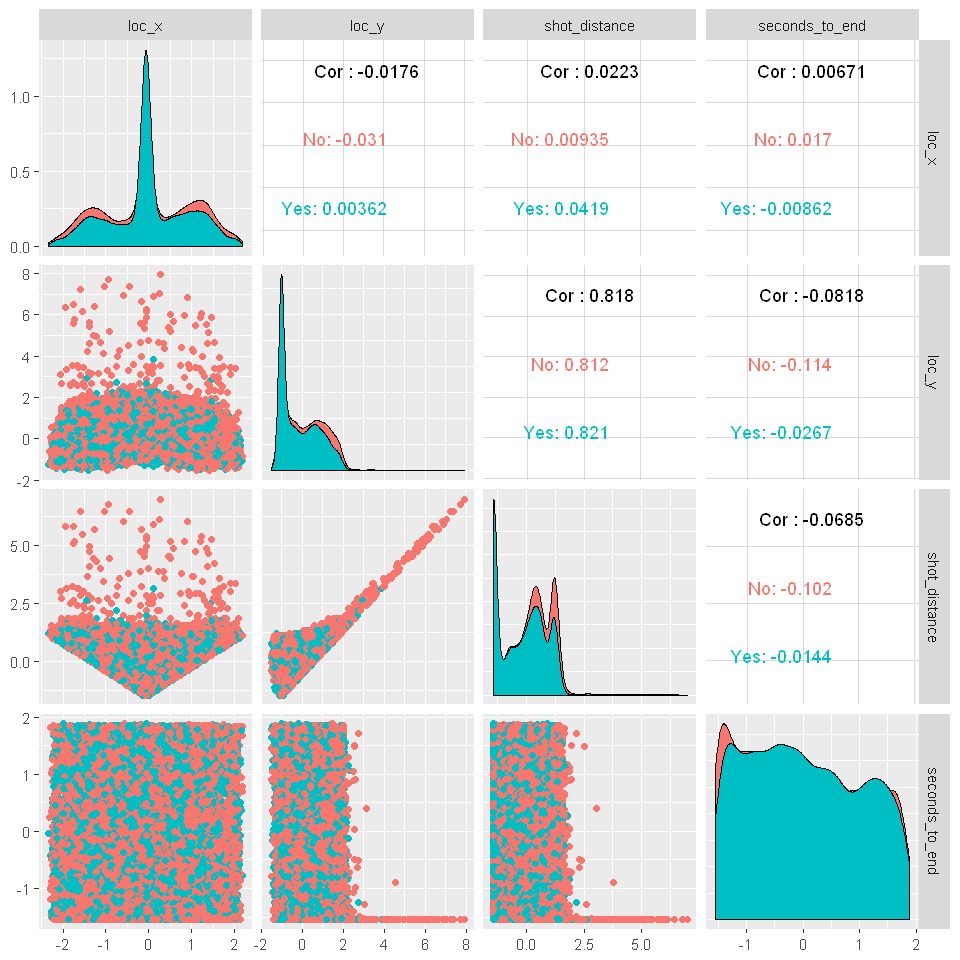

In [24]:
# Scatter matrix of 'loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'
options(repr.plot.width=8, repr.plot.height=8)
pm <- ggpairs(data_cl, mapping = aes(color = shot_made_flag), columns = c("loc_x", "loc_y", "shot_distance", "seconds_to_end"))
pm

### Histograms

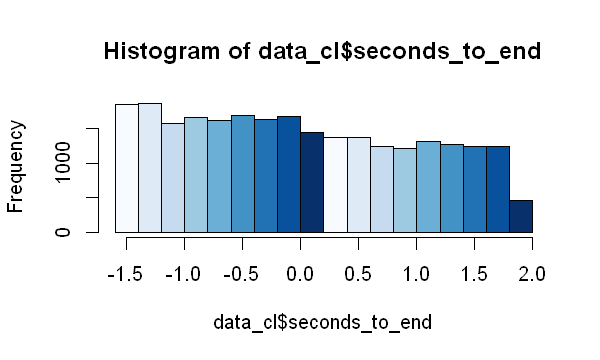

In [25]:
options(repr.plot.width=5, repr.plot.height=3)
hist(data_cl$seconds_to_end, col=blues9)

## Models

### Pre-processing

In [26]:
set.seed(300)

# Spliting data as training and test set. Using createDataPartition() function from caret
idxTrain <- createDataPartition(y = data_cl$shot_made_flag, p = 0.8, list = FALSE)
training <- data_cl[idxTrain,]
testing <- data_cl[-idxTrain,]

#### Checking distibution in origanl data and partitioned data

In [27]:
# Orignal
prop.table(table(data_cl$shot_made_flag)) * 100


     No     Yes 
55.3839 44.6161 

In [28]:
# Training
prop.table(table(training$shot_made_flag)) * 100


      No      Yes 
55.38477 44.61523 

In [29]:
# Testing
prop.table(table(testing$shot_made_flag)) * 100


      No      Yes 
55.38042 44.61958 

#### Train control

In [30]:
set.seed(400)
ctrl <- trainControl(method="repeatedcv", number = 10, repeats = 1, verboseIter = TRUE)

### KNN

In [32]:
start.time <- Sys.time()
knnFit <- caret:::train(shot_made_flag ~ ., data = training, method = "knn", 
                trControl = ctrl, tuneLength = 5)

#Output of kNN fit
knnFit

# Time elapsed
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

+ Fold01.Rep1: k= 5 
- Fold01.Rep1: k= 5 
+ Fold01.Rep1: k= 7 
- Fold01.Rep1: k= 7 
+ Fold01.Rep1: k= 9 
- Fold01.Rep1: k= 9 
+ Fold01.Rep1: k=11 
- Fold01.Rep1: k=11 
+ Fold01.Rep1: k=13 
- Fold01.Rep1: k=13 
+ Fold02.Rep1: k= 5 
- Fold02.Rep1: k= 5 
+ Fold02.Rep1: k= 7 
- Fold02.Rep1: k= 7 
+ Fold02.Rep1: k= 9 
- Fold02.Rep1: k= 9 
+ Fold02.Rep1: k=11 
- Fold02.Rep1: k=11 
+ Fold02.Rep1: k=13 
- Fold02.Rep1: k=13 
+ Fold03.Rep1: k= 5 
- Fold03.Rep1: k= 5 
+ Fold03.Rep1: k= 7 
- Fold03.Rep1: k= 7 
+ Fold03.Rep1: k= 9 
- Fold03.Rep1: k= 9 
+ Fold03.Rep1: k=11 
- Fold03.Rep1: k=11 
+ Fold03.Rep1: k=13 
- Fold03.Rep1: k=13 
+ Fold04.Rep1: k= 5 
- Fold04.Rep1: k= 5 
+ Fold04.Rep1: k= 7 
- Fold04.Rep1: k= 7 
+ Fold04.Rep1: k= 9 
- Fold04.Rep1: k= 9 
+ Fold04.Rep1: k=11 
- Fold04.Rep1: k=11 
+ Fold04.Rep1: k=13 
- Fold04.Rep1: k=13 
+ Fold05.Rep1: k= 5 
- Fold05.Rep1: k= 5 
+ Fold05.Rep1: k= 7 
- Fold05.Rep1: k= 7 
+ Fold05.Rep1: k= 9 
- Fold05.Rep1: k= 9 
+ Fold05.Rep1: k=11 
- Fold05.Rep1

k-Nearest Neighbors 

20558 samples
  147 predictor
    2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 18503, 18502, 18502, 18503, 18502, 18501, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.5945631  0.1642545
   7  0.6075024  0.1877670
   9  0.6088161  0.1876757
  11  0.6140696  0.1962488
  13  0.6163069  0.1993130

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was k = 13. 

Time difference of 16.55802 mins

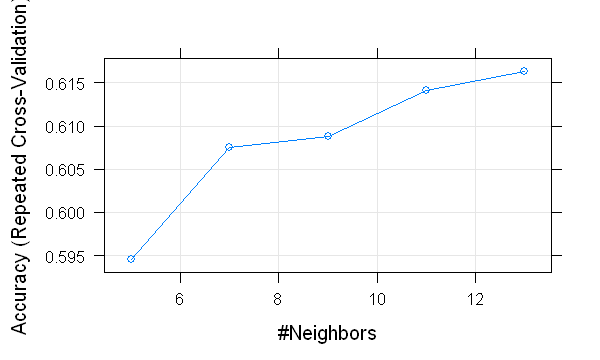

In [33]:
# Plot Accuracy of the cross validation
plot(knnFit)

In [36]:
# Now predict on test set
knnPredict <- predict(knnFit, newdata = testing)
# Get the confusion matrix to see accuracy value and other parameter values
caret:::confusionMatrix(knnPredict, testing$shot_made_flag, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  2182 1326
       Yes  664  967
                                          
               Accuracy : 0.6128          
                 95% CI : (0.5993, 0.6261)
    No Information Rate : 0.5538          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.1938          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4217          
            Specificity : 0.7667          
         Pos Pred Value : 0.5929          
         Neg Pred Value : 0.6220          
             Prevalence : 0.4462          
         Detection Rate : 0.1882          
   Detection Prevalence : 0.3174          
      Balanced Accuracy : 0.5942          
                                          
       'Positive' Class : Yes             
                                          

### Logistic Regression

In [37]:
start.time <- Sys.time()
LRfit <- caret:::train(shot_made_flag ~ ., data = training, method = "glm", family = binomial, trControl = ctrl)

#Output of kNN fit
LRfit

# Time elapsed
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

+ Fold01.Rep1: parameter=none 


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

- Fold01.Rep1: parameter=none 
+ Fold02.Rep1: parameter=none 


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

- Fold02.Rep1: parameter=none 
+ Fold03.Rep1: parameter=none 


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

- Fold03.Rep1: parameter=none 
+ Fold04.Rep1: parameter=none 


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

- Fold04.Rep1: parameter=none 
+ Fold05.Rep1: parameter=none 


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

- Fold05.Rep1: parameter=none 
+ Fold06.Rep1: parameter=none 


Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

- Fold06.Rep1: parameter=none 
+ Fold07.Rep1: parameter=none 


Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

- Fold07.Rep1: parameter=none 
+ Fold08.Rep1: parameter=none 


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

- Fold08.Rep1: parameter=none 
+ Fold09.Rep1: parameter=none 


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

- Fold09.Rep1: parameter=none 
+ Fold10.Rep1: parameter=none 


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

- Fold10.Rep1: parameter=none 
Aggregating results
Fitting final model on full training set


Generalized Linear Model 

20558 samples
  147 predictor
    2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 18502, 18503, 18502, 18502, 18502, 18502, ... 
Resampling results:

  Accuracy   Kappa    
  0.6786659  0.3251416

 

Time difference of 1.612649 mins

In [38]:
# Now predict on test set
LRPredict <- predict(LRfit, newdata = testing)
# Get the confusion matrix to see accuracy value and other parameter values
caret:::confusionMatrix(LRPredict, testing$shot_made_flag, positive = "Yes")

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  2481 1208
       Yes  365 1085
                                          
               Accuracy : 0.6939          
                 95% CI : (0.6811, 0.7065)
    No Information Rate : 0.5538          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3577          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4732          
            Specificity : 0.8717          
         Pos Pred Value : 0.7483          
         Neg Pred Value : 0.6725          
             Prevalence : 0.4462          
         Detection Rate : 0.2111          
   Detection Prevalence : 0.2822          
      Balanced Accuracy : 0.6725          
                                          
       'Positive' Class : Yes             
                                          

### Naive Bayes

In [39]:
start.time <- Sys.time()
NBfit <- caret:::train(shot_made_flag ~ ., data = training, method = "nb", trControl = ctrl)

#Output of NB fit
NBfit

# Time elapsed
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Loading required package: klaR
Warning message:
"package 'klaR' was built under R version 3.3.2"Loading required package: MASS


+ Fold01.Rep1: usekernel= TRUE, fL=0, adjust=1 
- Fold01.Rep1: usekernel= TRUE, fL=0, adjust=1 
+ Fold01.Rep1: usekernel=FALSE, fL=0, adjust=1 
model fit failed for Fold01.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Driving.Bank.shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot., X.shot_zone_area.Back.Court.BC.., X.shot_zone_basic.Backcourt., X.shot_zone_range.Back.Court.Shot.
 


Warning message in eval(expr, envir, enclos):
"model fit failed for Fold01.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Driving.Bank.shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot., X.shot_zone_area.Back.Court.BC.., X.shot_zone_basic.Backcourt., X.shot_zone_range.Back.Court.Shot.
"

- Fold01.Rep1: usekernel=FALSE, fL=0, adjust=1 
+ Fold02.Rep1: usekernel= TRUE, fL=0, adjust=1 
- Fold02.Rep1: usekernel= TRUE, fL=0, adjust=1 
+ Fold02.Rep1: usekernel=FALSE, fL=0, adjust=1 
model fit failed for Fold02.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Jump.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
 


Warning message in eval(expr, envir, enclos):
"model fit failed for Fold02.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Jump.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
"

- Fold02.Rep1: usekernel=FALSE, fL=0, adjust=1 
+ Fold03.Rep1: usekernel= TRUE, fL=0, adjust=1 
- Fold03.Rep1: usekernel= TRUE, fL=0, adjust=1 
+ Fold03.Rep1: usekernel=FALSE, fL=0, adjust=1 
model fit failed for Fold03.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Running.Finger.Roll.Shot., X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Driving.Bank.shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Jump.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
 


Warning message in eval(expr, envir, enclos):
"model fit failed for Fold03.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Running.Finger.Roll.Shot., X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Driving.Bank.shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Jump.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
"

- Fold03.Rep1: usekernel=FALSE, fL=0, adjust=1 
+ Fold04.Rep1: usekernel= TRUE, fL=0, adjust=1 
- Fold04.Rep1: usekernel= TRUE, fL=0, adjust=1 
+ Fold04.Rep1: usekernel=FALSE, fL=0, adjust=1 
model fit failed for Fold04.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Tip.Layup.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
 


Warning message in eval(expr, envir, enclos):
"model fit failed for Fold04.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Tip.Layup.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
"

- Fold04.Rep1: usekernel=FALSE, fL=0, adjust=1 
+ Fold05.Rep1: usekernel= TRUE, fL=0, adjust=1 
- Fold05.Rep1: usekernel= TRUE, fL=0, adjust=1 
+ Fold05.Rep1: usekernel=FALSE, fL=0, adjust=1 
model fit failed for Fold05.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Running.Finger.Roll.Shot., X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Tip.Layup.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
 


Warning message in eval(expr, envir, enclos):
"model fit failed for Fold05.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Running.Finger.Roll.Shot., X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Tip.Layup.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
"

- Fold05.Rep1: usekernel=FALSE, fL=0, adjust=1 
+ Fold06.Rep1: usekernel= TRUE, fL=0, adjust=1 
- Fold06.Rep1: usekernel= TRUE, fL=0, adjust=1 
+ Fold06.Rep1: usekernel=FALSE, fL=0, adjust=1 
model fit failed for Fold06.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Hook.Shot., X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
 


Warning message in eval(expr, envir, enclos):
"model fit failed for Fold06.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Hook.Shot., X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
"

- Fold06.Rep1: usekernel=FALSE, fL=0, adjust=1 
+ Fold07.Rep1: usekernel= TRUE, fL=0, adjust=1 
- Fold07.Rep1: usekernel= TRUE, fL=0, adjust=1 
+ Fold07.Rep1: usekernel=FALSE, fL=0, adjust=1 
model fit failed for Fold07.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Running.Pull.Up.Jump.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
 


Warning message in eval(expr, envir, enclos):
"model fit failed for Fold07.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Running.Pull.Up.Jump.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
"

- Fold07.Rep1: usekernel=FALSE, fL=0, adjust=1 
+ Fold08.Rep1: usekernel= TRUE, fL=0, adjust=1 
- Fold08.Rep1: usekernel= TRUE, fL=0, adjust=1 
+ Fold08.Rep1: usekernel=FALSE, fL=0, adjust=1 
model fit failed for Fold08.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Follow.Up.Dunk.Shot., X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Putback.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
 


Warning message in eval(expr, envir, enclos):
"model fit failed for Fold08.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Follow.Up.Dunk.Shot., X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Putback.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
"

- Fold08.Rep1: usekernel=FALSE, fL=0, adjust=1 
+ Fold09.Rep1: usekernel= TRUE, fL=0, adjust=1 
- Fold09.Rep1: usekernel= TRUE, fL=0, adjust=1 
+ Fold09.Rep1: usekernel=FALSE, fL=0, adjust=1 
model fit failed for Fold09.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
 


Warning message in eval(expr, envir, enclos):
"model fit failed for Fold09.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
"

- Fold09.Rep1: usekernel=FALSE, fL=0, adjust=1 
+ Fold10.Rep1: usekernel= TRUE, fL=0, adjust=1 
- Fold10.Rep1: usekernel= TRUE, fL=0, adjust=1 
+ Fold10.Rep1: usekernel=FALSE, fL=0, adjust=1 
model fit failed for Fold10.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Cutting.Layup.Shot., X.action_type.Running.Pull.Up.Jump.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
 


Warning message in eval(expr, envir, enclos):
"model fit failed for Fold10.Rep1: usekernel=FALSE, fL=0, adjust=1 Error in NaiveBayes.default(x, y, usekernel = FALSE, fL = param$fL, ...) : 
  Zero variances for at least one class in variables: X.action_type.Turnaround.Finger.Roll.Shot., X.action_type.Hook.Bank.Shot., X.action_type.Running.Tip.Shot., X.action_type.Driving.Slam.Dunk.Shot., X.action_type.Reverse.Slam.Dunk.Shot., X.action_type.Putback.Slam.Dunk.Shot., X.action_type.Running.Slam.Dunk.Shot., X.action_type.Cutting.Layup.Shot., X.action_type.Running.Pull.Up.Jump.Shot., X.action_type.Driving.Floating.Bank.Jump.Shot.
"

- Fold10.Rep1: usekernel=FALSE, fL=0, adjust=1 


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

Aggregating results


Warning message in train.default(x, y, weights = w, ...):
"missing values found in aggregated results"

Selecting tuning parameters
Fitting fL = 0, usekernel = TRUE, adjust = 1 on full training set


Naive Bayes 

20558 samples
  147 predictor
    2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 18502, 18502, 18503, 18502, 18503, 18502, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy  Kappa     
  FALSE           NaN         NaN
   TRUE      0.560657  0.01846162

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using  the largest value.
The final values used for the model were fL = 0, usekernel = TRUE and adjust
 = 1. 

Time difference of 4.909849 mins

In [40]:
# Now predict on test set
NBPredict <- predict(NBfit, newdata = testing)
# Get the confusion matrix to see accuracy value and other parameter values
caret:::confusionMatrix(NBPredict, testing$shot_made_flag, positive = "Yes")


Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  2846 2293
       Yes    0    0
                                          
               Accuracy : 0.5538          
                 95% CI : (0.5401, 0.5675)
    No Information Rate : 0.5538          
    P-Value [Acc > NIR] : 0.5058          
                                          
                  Kappa : 0               
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.5538          
             Prevalence : 0.4462          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : Yes             
                                          

### Linear SVM

+ Fold01.Rep1: cost=0.25 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold01.Rep1: cost=0.25 
+ Fold01.Rep1: cost=0.50 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold01.Rep1: cost=0.50 
+ Fold01.Rep1: cost=1.00 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold01.Rep1: cost=1.00 
+ Fold02.Rep1: cost=0.25 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Running.Tip.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold02.Rep1: cost=0.25 
+ Fold02.Rep1: cost=0.50 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Running.Tip.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold02.Rep1: cost=0.50 
+ Fold02.Rep1: cost=1.00 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Running.Tip.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold02.Rep1: cost=1.00 
+ Fold03.Rep1: cost=0.25 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Putback.Slam.Dunk.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold03.Rep1: cost=0.25 
+ Fold03.Rep1: cost=0.50 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Putback.Slam.Dunk.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold03.Rep1: cost=0.50 
+ Fold03.Rep1: cost=1.00 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Putback.Slam.Dunk.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold03.Rep1: cost=1.00 
+ Fold04.Rep1: cost=0.25 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Jump.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold04.Rep1: cost=0.25 
+ Fold04.Rep1: cost=0.50 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Jump.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold04.Rep1: cost=0.50 
+ Fold04.Rep1: cost=1.00 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Jump.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold04.Rep1: cost=1.00 
+ Fold05.Rep1: cost=0.25 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold05.Rep1: cost=0.25 
+ Fold05.Rep1: cost=0.50 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold05.Rep1: cost=0.50 
+ Fold05.Rep1: cost=1.00 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold05.Rep1: cost=1.00 
+ Fold06.Rep1: cost=0.25 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold06.Rep1: cost=0.25 
+ Fold06.Rep1: cost=0.50 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold06.Rep1: cost=0.50 
+ Fold06.Rep1: cost=1.00 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold06.Rep1: cost=1.00 
+ Fold07.Rep1: cost=0.25 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold07.Rep1: cost=0.25 
+ Fold07.Rep1: cost=0.50 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold07.Rep1: cost=0.50 
+ Fold07.Rep1: cost=1.00 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold07.Rep1: cost=1.00 
+ Fold08.Rep1: cost=0.25 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Running.Slam.Dunk.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold08.Rep1: cost=0.25 
+ Fold08.Rep1: cost=0.50 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Running.Slam.Dunk.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold08.Rep1: cost=0.50 
+ Fold08.Rep1: cost=1.00 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Running.Slam.Dunk.Shot.' and 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold08.Rep1: cost=1.00 
+ Fold09.Rep1: cost=0.25 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold09.Rep1: cost=0.25 
+ Fold09.Rep1: cost=0.50 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold09.Rep1: cost=0.50 
+ Fold09.Rep1: cost=1.00 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold09.Rep1: cost=1.00 
+ Fold10.Rep1: cost=0.25 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold10.Rep1: cost=0.25 
+ Fold10.Rep1: cost=0.50 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold10.Rep1: cost=0.50 
+ Fold10.Rep1: cost=1.00 


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

- Fold10.Rep1: cost=1.00 
Aggregating results
Selecting tuning parameters
Fitting cost = 0.5 on full training set


Warning message in svm.default(x = as.matrix(x), y = y, kernel = "linear", cost = param$cost, :
"Variable(s) 'X.action_type.Driving.Floating.Bank.Jump.Shot.' constant. Cannot scale data."

Support Vector Machines with Linear Kernel 

20558 samples
  147 predictor
    2 classes: 'No', 'Yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 18502, 18502, 18502, 18502, 18503, 18501, ... 
Resampling results across tuning parameters:

  cost  Accuracy   Kappa    
  0.25  0.6769614  0.3224712
  0.50  0.6774964  0.3236201
  1.00  0.6774964  0.3239375

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was cost = 0.5. 

Time difference of 21.50802 mins

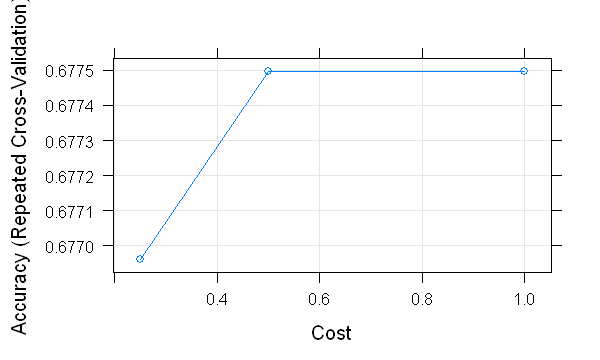

In [41]:
start.time <- Sys.time()
SVMfit <- caret:::train(shot_made_flag ~ ., data = training, method = "svmLinear2", trControl = ctrl)

#Output of NB fit
SVMfit

# Time elapsed
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

# Plot the tuning
plot(SVMfit)

In [43]:
# Now predict on test set
SVMPredict <- predict(SVMfit, newdata = testing)
# Get the confusion matrix to see accuracy value and other parameter values
caret:::confusionMatrix(SVMPredict, testing$shot_made_flag, positive = "Yes")

Confusion Matrix and Statistics

          Reference
Prediction   No  Yes
       No  2449 1181
       Yes  397 1112
                                          
               Accuracy : 0.6929          
                 95% CI : (0.6801, 0.7055)
    No Information Rate : 0.5538          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3573          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4850          
            Specificity : 0.8605          
         Pos Pred Value : 0.7369          
         Neg Pred Value : 0.6747          
             Prevalence : 0.4462          
         Detection Rate : 0.2164          
   Detection Prevalence : 0.2936          
      Balanced Accuracy : 0.6727          
                                          
       'Positive' Class : Yes             
                                          

### Random Forest

In [ ]:
start.time <- Sys.time()
rfctrl <- trainControl(method="repeatedcv", number = 10, repeats = 1, verboseIter = TRUE, classProbs = TRUE)
RFfit <- caret:::train(shot_made_flag ~ ., data = training, method = "rf", tuneLength = 10, metric="ROC", trControl = rfctrl)

#Output of NB fit
RFfit

# Time elapsed
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

# Plot the tuning
plot(RFfit)

Warning message in train.default(x, y, weights = w, ...):
"The metric "ROC" was not in the result set. Accuracy will be used instead."

In [ ]:
# Now predict on test set
RFPredict <- predict(RFfit, newdata = testing)
# Get the confusion matrix to see accuracy value and other parameter values
caret:::confusionMatrix(RFPredict, testing$shot_made_flag, positive = "Yes")

### Neural Networks

#### 1 Hidden Layer - 1:6 Units

In [ ]:
start.time <- Sys.time()
my.grid <- expand.grid(.decay = c(2, 1), .size = c(1,2,3,4,5,6))
NNETfit <- caret:::train(shot_made_flag ~ ., data = training, method = "nnet", maxit = 10000, tuneGrid = my.grid, trace = F, trControl = rfctrl)

#Output of NB fit
NNETfit

# Time elapsed
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

# Plot optimization
plot(NNETfit)

In [ ]:
# Now predict on test set
NNETPredict <- predict(NNETfit, newdata = testing)
# Get the confusion matrix to see accuracy value and other parameter values
caret:::confusionMatrix(NNETPredict, testing$shot_made_flag, positive = "Yes")

#### MLP

In [ ]:
start.time <- Sys.time()

seeds <- vector(mode = "list", length = nrow(training) + 1)
seeds <- lapply(seeds, function(x) 1:54)
cctrl1 <- trainControl(method = "cv", number = 10, verboseIter = TRUE)

grid <- expand.grid(decay = c(0, .01), layer1 = 1:3, layer2 = 1:3, layer3 = 1:3)

NEURALNETfit <- caret:::train(data_cl[, !(colnames(data_cl) %in% c("shot_made_flag"))],
                                     data_cl$shot_made_flag,
                                     method = "mlpWeightDecayML",
                                     trControl = cctrl1,
                                     tuneGrid = grid)


# Time elapsed
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

In [ ]:
# Now predict on test set
NEURALNETPredict <- predict(NEURALNETfit, newdata = testing)
# Get the confusion matrix to see accuracy value and other parameter values
caret:::confusionMatrix(NEURALNETPredict, testing$shot_made_flag, positive = "Yes")